In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose


In [2]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [3]:
FEATURES = pd.read_csv("features.csv")
STORES = pd.read_csv("stores.csv")
TEST = pd.read_csv("test.csv")
TRAIN = pd.read_csv("train.csv")

In [4]:
# print("Features:\n",FEATURES.head())
# print("Stores:\n",STORES.head())
# print("Test:\n", TEST.head())
# print("Train:\n", TRAIN.head())

___
# Merging Stores and Features with train and test to add external features
---

In [5]:
# First Merging the training dataset 
full_training_dataset = pd.merge(FEATURES, TRAIN, how="left", on=["Store", "Date", "IsHoliday"])

full_training_dataset = pd.merge(full_training_dataset, STORES, on=["Store"], how="left")

In [6]:

# NOW Merging the testing dataset
full_testing_dataset = pd.merge(FEATURES, TEST, on=['Store', 'Date', 'IsHoliday'], how="left")
full_testing_dataset = pd.merge(full_testing_dataset, STORES, how="left")

In [7]:
print(full_training_dataset.shape)
print(full_testing_dataset.shape)

(423325, 16)
(121499, 15)


In [8]:
# full_training_dataset

In [9]:
full_training_dataset['Date'] = pd.to_datetime(full_training_dataset['Date'])
full_testing_dataset['Date'] = pd.to_datetime(full_testing_dataset['Date'])


# INDEXING via Time
full_training_dataset.set_index('Date', inplace=True)
full_testing_dataset.set_index('Date', inplace=True)

___
# Prepping Data 
---

In [10]:
# print("Training :",full_training_dataset.isnull().sum(), " |||| Testing: ",full_testing_dataset.isnull().sum())

In [11]:
# Dealing with Markdowns by assigning 0s to missing values
for col in ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']:
    full_training_dataset[col] = full_training_dataset[col].fillna(0)
    full_testing_dataset[col] = full_testing_dataset[col].fillna(0)
    

In [12]:
# Dealing with Missing CPI and Unemployment Features

full_training_dataset['CPI'] = full_training_dataset['CPI'].ffill()
full_testing_dataset['CPI'] = full_testing_dataset['CPI'].ffill()

full_training_dataset['Unemployment'] = full_training_dataset['Unemployment'].ffill()
full_testing_dataset['Unemployment'] = full_testing_dataset['Unemployment'].ffill()

In [13]:
# DEaling with missing Departments and Weekly_Sales

full_training_dataset = full_training_dataset.dropna(subset=['Dept', 'Weekly_Sales'])
full_testing_dataset = full_testing_dataset.dropna(subset=['Dept'])

___
# Initial Data Visualizing
---

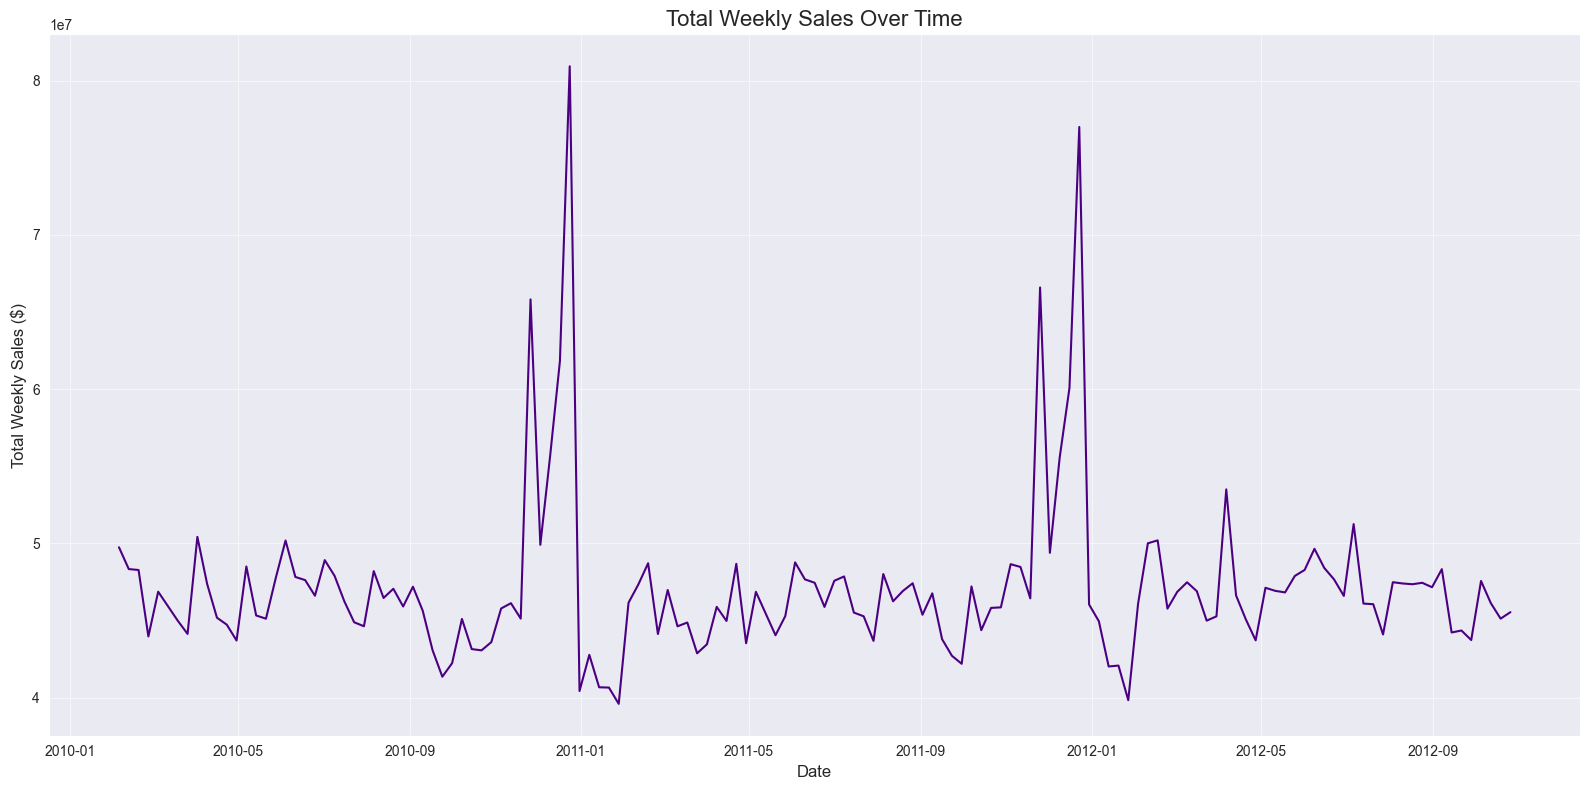

In [14]:
# Group the data by 'Date' and sum the 'Weekly_Sales' for each date
daily_sales = full_training_dataset.groupby('Date')['Weekly_Sales'].sum()

# --- 3. Plot the data ---
plt.figure(figsize=(16, 8))
plt.plot(daily_sales.index, daily_sales.values, linestyle='-', color='indigo')

# Add titles and labels
plt.title("Total Weekly Sales Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Weekly Sales ($)", fontsize=12)

# Add a grid for better readability
plt.grid(True, alpha=0.6)

# Ensure the entire plot fits well
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\precision\AppData\Local\Temp\ipykernel_7988\2793799073.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


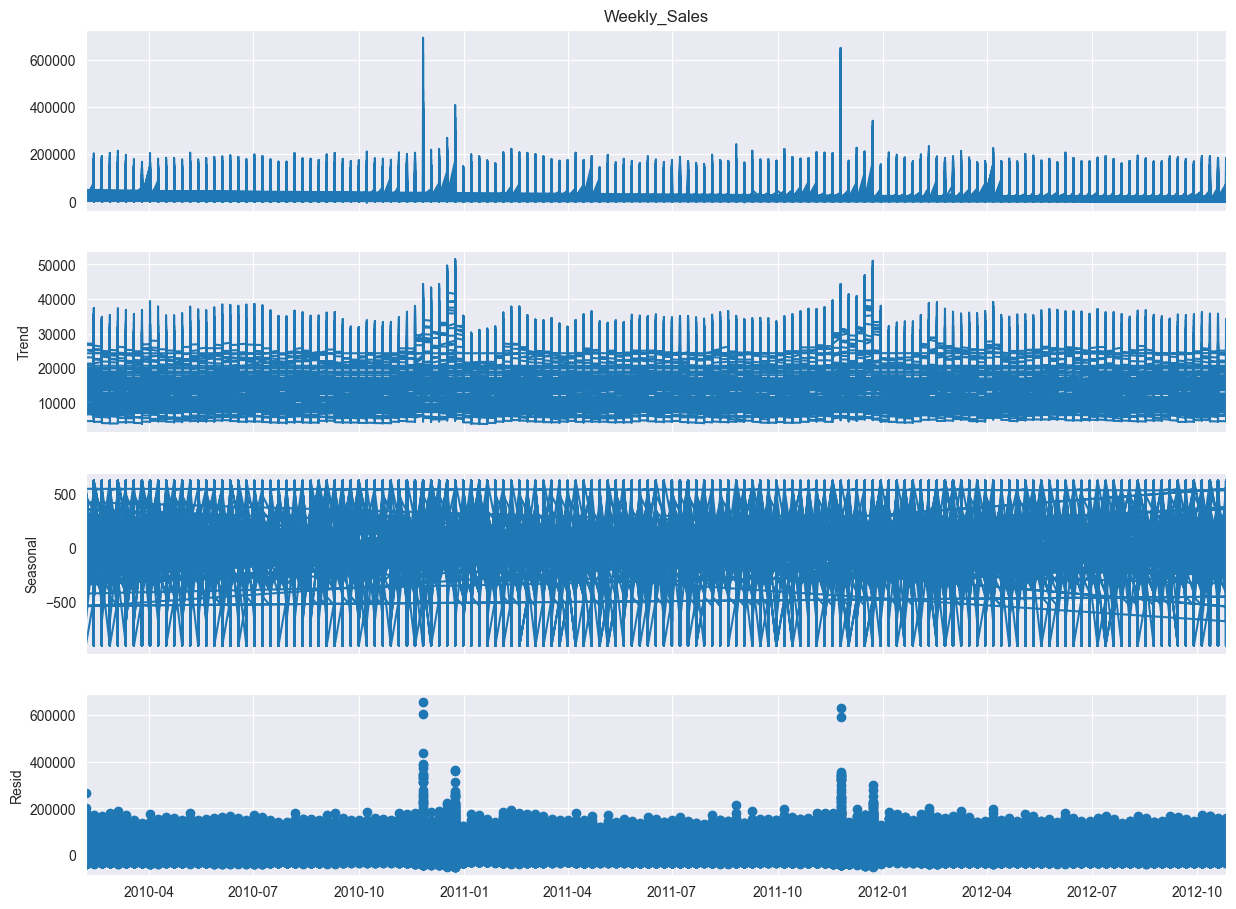

In [15]:
# Time Series Decomposition and Trends
result = seasonal_decompose(full_training_dataset['Weekly_Sales'], model='additive', period=104)

fig = result.plot()
fig.set_size_inches(14, 10)

fig.show()


___
# Feature Engineering
-
_Extracting signals via data to feed the model_

1- Calendar-Based Featuring:
```
Purpose: Give the model context about when the sale happens.

Example:

Sales spike in December (month = 12).

Sales dip on Tuesdays (day_of_week = 1).

Without these, the model only sees numbers, not seasonality patterns tied to the calendar.
```

In [16]:
full_training_dataset['year'] = full_training_dataset.index.year
full_training_dataset['month'] = full_training_dataset.index.month
full_training_dataset['week_of_year'] = full_training_dataset.index.isocalendar().week.astype(int)
full_training_dataset['day_of_week'] = full_training_dataset.index.dayofweek  # Monday=0, Sunday=6

# Example holiday flag (adjust according to Walmart data)
full_training_dataset['is_holiday_season'] = full_training_dataset['month'].isin([11, 12]).astype(int)

2- Lag Feature
```
Purpose: Tell the model what just happened recently.

Example:

If sales last week (lag_1) were high, this week will probably also be high.

If sales this week last year (lag_52) were high, expect a similar spike this year (Christmas, Thanksgiving, etc.).

Lags capture momentum and seasonal recurrence.
```

In [17]:
# Lags to create
lags = [1, 2, 4, 52]

for lag in lags:
    full_training_dataset[f'lag_{lag}'] = (
        full_training_dataset.groupby(['Store', 'Dept'])['Weekly_Sales']
          .shift(lag)
    )
# We group by Store and Department cuz every Dept has its own timeline in every different store so to avoid them catching other's Lag we make lags by grouping the same Depts and Stores Together

3 - Window Rolling Feature

```
Purpose: Smooth out noise and describe trends/volatility.

Example:

4-week rolling mean = recent baseline (better than relying on just one noisy week).

Rolling std = were sales stable or volatile recently?

These features help the model detect trends (“sales are growing steadily”) vs spikes (“sales suddenly jumped”).
```

In [18]:
windows = [4, 12, 52]  # short, medium, long

for w in windows:
    full_training_dataset[f'rolling_mean_{w}'] = (
        full_training_dataset.groupby(['Store', 'Dept'])['Weekly_Sales']
          .shift(1).rolling(window=w).mean()
    )
    full_training_dataset[f'rolling_std_{w}'] = (
        full_training_dataset.groupby(['Store', 'Dept'])['Weekly_Sales']
          .shift(1).rolling(window=w).std()
    )
    full_training_dataset[f'rolling_min_{w}'] = (
        full_training_dataset.groupby(['Store', 'Dept'])['Weekly_Sales']
          .shift(1).rolling(window=w).min()
    )
    full_training_dataset[f'rolling_max_{w}'] = (
        full_training_dataset.groupby(['Store', 'Dept'])['Weekly_Sales']
          .shift(1).rolling(window=w).max()
    )


In [19]:
full_training_dataset = full_training_dataset.dropna().copy()


___
# Training Model to Forecast

Prepping the data to Train

In [20]:
train_df = full_training_dataset.copy()

In [21]:
y = train_df['Weekly_Sales']
X = train_df.drop(columns=['Weekly_Sales'])

In [22]:
# One hot encoding the categoricals

categorical_features = ['Type', 'IsHoliday']
numeric_features = [col for col in X.columns if col not in categorical_features]


# Making the Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ]
)


-
Train Test Split without randomizing to evaluate the data

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

___
# 1 - LinearRegression:

- Building a Pipeline for cleaner and robust implementation 

In [24]:
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [25]:
lr_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True



### Evaluation:

In [26]:
y_pred = lr_pipeline.predict(X_val)

In [41]:
print("lINEAR rEG MAE:", mean_absolute_error(y_val, y_pred))
print(f"Linear Regression RMSE: {np.sqrt(mean_squared_error(y_val, y_pred))}")
print(f"Linear Regression R²: {r2_score(y_val, y_pred)}")

lINEAR rEG MAE: 1471.5888966113666
Linear Regression RMSE: 3168.020217041023
Linear Regression R²: 0.9730275987444165


___
# 2 - XGBoost:

- Building a Pipeline for cleaner and robust implementation 

In [28]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        eval_metric="rmse",
        early_stopping_rounds=50
    ))
])

In [29]:
xgb_pipeline.fit(
    X_train, y_train,
    model__eval_set=[(preprocessor.transform(X_val), y_val)]              
)

[0]	validation_0-rmse:18705.67931
[1]	validation_0-rmse:17828.25806
[2]	validation_0-rmse:16998.52075
[3]	validation_0-rmse:16210.64526
[4]	validation_0-rmse:15459.44245
[5]	validation_0-rmse:14769.46815
[6]	validation_0-rmse:14093.48380
[7]	validation_0-rmse:13453.88098
[8]	validation_0-rmse:12844.59451
[9]	validation_0-rmse:12273.34148
[10]	validation_0-rmse:11723.24615
[11]	validation_0-rmse:11207.25666
[12]	validation_0-rmse:10732.11270
[13]	validation_0-rmse:10263.48931
[14]	validation_0-rmse:9828.34165
[15]	validation_0-rmse:9417.66252
[16]	validation_0-rmse:9028.03517
[17]	validation_0-rmse:8661.41623
[18]	validation_0-rmse:8320.87109
[19]	validation_0-rmse:7984.32795
[20]	validation_0-rmse:7670.67697
[21]	validation_0-rmse:7383.48858
[22]	validation_0-rmse:7108.16487
[23]	validation_0-rmse:6851.21219
[24]	validation_0-rmse:6598.95967
[25]	validation_0-rmse:6376.39178
[26]	validation_0-rmse:6157.53249
[27]	validation_0-rmse:5968.38990
[28]	validation_0-rmse:5772.68776
[29]	valid

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Evalustion:

In [30]:
y_pred_xgb = xgb_pipeline.predict(X_val)
print("XGBoost MAE:", mean_absolute_error(y_val, y_pred_xgb))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_xgb)))
print("XGBoost R²:", r2_score(y_val, y_pred_xgb))

XGBoost MAE: 1224.2218666961455
XGBoost RMSE: 3062.3288485793714
XGBoost R²: 0.9747972823332273


___
# Forecasting on the test dataset:

In [31]:
def create_features(df):
    """
    Creates lag and rolling mean features for a given DataFrame.
    This function is necessary for the forecasting loop to work.
    """
    # Create lag features
    for lag in [1, 2, 4, 52]:
        df[f"lag_{lag}"] = df.groupby(["Store", "Dept"])["Weekly_Sales"].shift(lag)

    # Create rolling mean and other features
    windows = [4, 12, 52]
    for w in windows:
        df[f"rolling_mean_{w}"] = df.groupby(["Store", "Dept"])["Weekly_Sales"].shift(1).rolling(w).mean()
        df[f"rolling_std_{w}"] = df.groupby(["Store", "Dept"])["Weekly_Sales"].shift(1).rolling(w).std()
        df[f"rolling_min_{w}"] = df.groupby(["Store", "Dept"])["Weekly_Sales"].shift(1).rolling(w).min()
        df[f"rolling_max_{w}"] = df.groupby(["Store", "Dept"])["Weekly_Sales"].shift(1).rolling(w).max()
    
    return df

# --- CORRECTED: Define the full set of features that the pipeline expects ---
numerical_features = ['Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
                      'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
                      'lag_1', 'lag_2', 'lag_4', 'lag_52']
for w in [4, 12, 52]:
    numerical_features.extend([f"rolling_mean_{w}", f"rolling_std_{w}", f"rolling_min_{w}", f"rolling_max_{w}"])

categorical_features = ['Store', 'Dept', 'IsHoliday', 'Type', 'year', 'month', 'week_of_year', 'day_of_week', 'is_holiday_season']

# --- Memory-efficient Forecasting ---
all_predictions = []
unique_combinations = full_testing_dataset[['Store', 'Dept']].drop_duplicates().values

print("Starting memory-efficient prediction...")
for store, dept in unique_combinations:
    # Get the historical data for this specific store and department
    history_subset = full_training_dataset[
        (full_training_dataset['Store'] == store) & 
        (full_training_dataset['Dept'] == dept)
    ].tail(52).copy()

    # Get the testing data for this specific store and department
    test_data = full_testing_dataset[
        (full_testing_dataset['Store'] == store) & 
        (full_testing_dataset['Dept'] == dept)
    ].copy()

    # Combine the small chunks to create features
    combined_chunk = pd.concat([history_subset, test_data])
    combined_chunk = create_features(combined_chunk)

    # Extract the test set rows from the chunk
    X_future_chunk = combined_chunk.loc[test_data.index][numerical_features + categorical_features]
    
    # Make predictions and append to the list
    chunk_pred = xgb_pipeline.predict(X_future_chunk)
    all_predictions.append(chunk_pred)

# Combine all predictions into a single array
y_future_pred = pd.Series([item for sublist in all_predictions for item in sublist], index=full_testing_dataset.index)

# Assign predictions to the test dataset
full_testing_dataset["Predicted_Weekly_Sales"] = y_future_pred

print("Forecasting complete.")


Starting memory-efficient prediction...
Forecasting complete.


In [32]:
full_testing_dataset

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Dept,Type,Size,Predicted_Weekly_Sales
Date,,,,,,,,,,,,,,,
2012-11-02,1,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,False,1.0,A,151315,28030.093750
2012-11-02,1,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,False,2.0,A,151315,66182.343750
2012-11-02,1,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,False,3.0,A,151315,71559.382812
2012-11-02,1,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,False,4.0,A,151315,73423.187500
2012-11-02,1,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,False,5.0,A,151315,100775.289062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-07-26,45,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,193.589304,8.335,False,93.0,B,118221,184463.296875
2013-07-26,45,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,193.589304,8.335,False,94.0,B,118221,181601.062500
2013-07-26,45,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,193.589304,8.335,False,95.0,B,118221,182250.343750


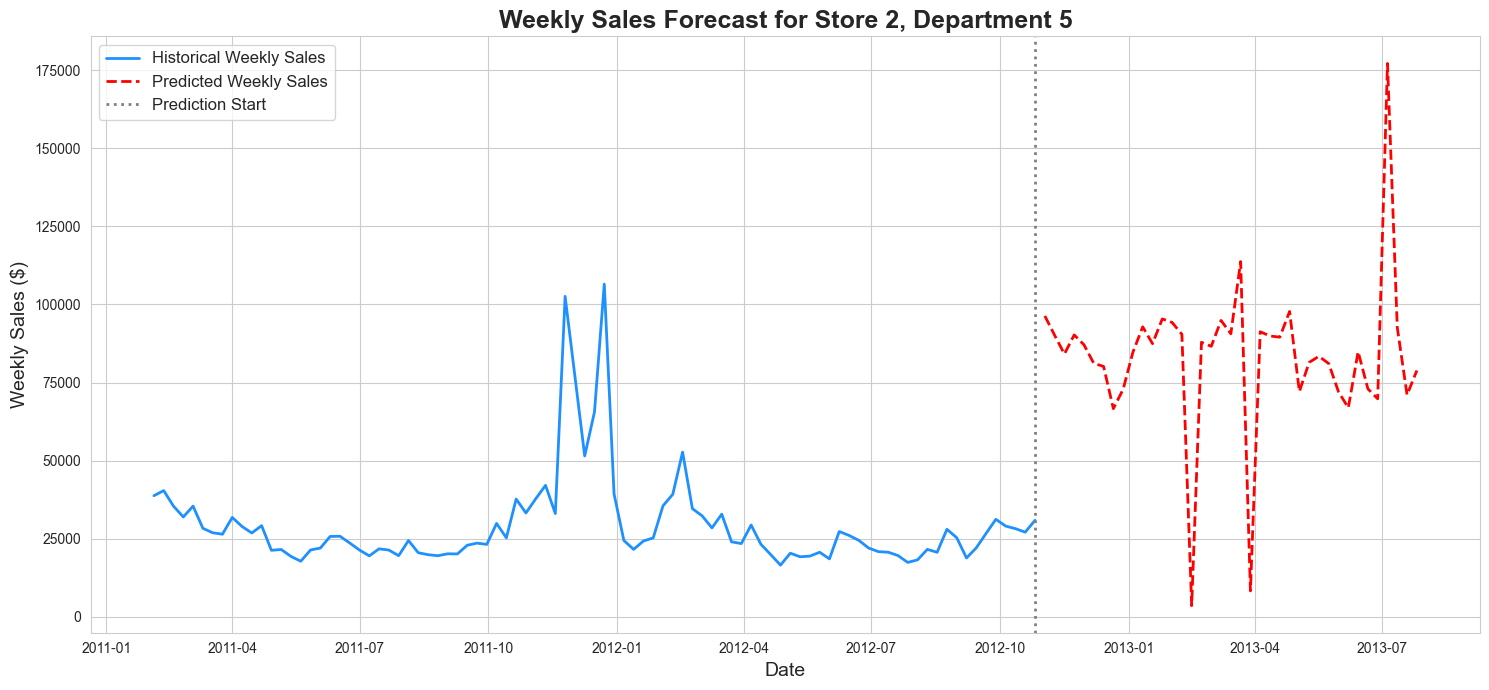

In [33]:
# Select the historical sales for one store and department to plot
# You can change these values to plot different data
store_id = 2
dept_id = 5

history_to_plot = full_training_dataset[
    (full_training_dataset['Store'] == store_id) & 
    (full_training_dataset['Dept'] == dept_id)
].copy()

forecast_to_plot = full_testing_dataset[
    (full_testing_dataset['Store'] == store_id) & 
    (full_testing_dataset['Dept'] == dept_id)
].copy()

# --- Plotting ---
plt.figure(figsize=(15, 7))
sns.set_style("whitegrid")

# Plot historical data as a solid blue line
plt.plot(history_to_plot.index, history_to_plot['Weekly_Sales'], 
         label='Historical Weekly Sales', color='dodgerblue', linewidth=2)

# Plot predicted data as a dashed red line
plt.plot(forecast_to_plot.index, forecast_to_plot['Predicted_Weekly_Sales'], 
         label='Predicted Weekly Sales', color='red', linestyle='--', linewidth=2)

# Add a vertical dashed line to separate past and future
last_history_date = history_to_plot.index[-1]
plt.axvline(x=last_history_date, color='grey', linestyle=':', linewidth=2, label='Prediction Start')

# --- Final Chart Styling ---
plt.title(f'Weekly Sales Forecast for Store {store_id}, Department {dept_id}', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales ($)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
full_training_dataset

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,...,rolling_min_4,rolling_max_4,rolling_mean_12,rolling_std_12,rolling_min_12,rolling_max_12,rolling_mean_52,rolling_std_52,rolling_min_52,rolling_max_52
Date,,,,,,,,,,,,,,,,,,,,,
2011-02-04,1,42.27,2.989,0.00,0.00,0.0,0.00,0.00,212.566881,7.742,...,10329.78,31942.34,51306.570000,38492.678785,3276.81,130891.97,19957.993654,28843.289779,-50.0,130891.97
2011-02-04,1,42.27,2.989,0.00,0.00,0.0,0.00,0.00,212.566881,7.742,...,10329.78,41651.01,54504.420000,35627.117580,10329.78,130891.97,20643.099231,28928.840872,-50.0,130891.97
2011-02-04,1,42.27,2.989,0.00,0.00,0.0,0.00,0.00,212.566881,7.742,...,10329.78,41651.01,52228.215000,37509.797775,10329.78,130891.97,20535.163462,28950.894989,-50.0,130891.97
2011-02-04,1,42.27,2.989,0.00,0.00,0.0,0.00,0.00,212.566881,7.742,...,11983.34,41651.01,48630.570000,37082.311559,10329.78,130891.97,21086.781154,28907.206232,-50.0,130891.97
2011-02-04,1,42.27,2.989,0.00,0.00,0.0,0.00,0.00,212.566881,7.742,...,11983.34,41651.01,45400.530000,37602.863817,10329.78,130891.97,21384.741154,28834.978075,-50.0,130891.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-10-26,45,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,...,2270.50,48108.38,12505.525833,13293.882885,740.05,48108.38,9074.658654,11723.848927,10.0,54427.64
2012-10-26,45,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,...,2270.50,48108.38,12160.596667,13451.677471,740.05,48108.38,9098.254423,11713.492986,10.0,54427.64
2012-10-26,45,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,...,2270.50,48434.97,15067.864167,17063.793092,740.05,48434.97,9535.438269,12725.823281,10.0,54427.64


In [35]:
import joblib

In [36]:
# joblib.dump(xgb_pipeline, 'xgb_forecasting_pipeline.joblib')

['xgb_forecasting_pipeline.joblib']

In [37]:
full_testing_dataset

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Dept,Type,Size,Predicted_Weekly_Sales
Date,,,,,,,,,,,,,,,
2012-11-02,1,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,False,1.0,A,151315,28030.093750
2012-11-02,1,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,False,2.0,A,151315,66182.343750
2012-11-02,1,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,False,3.0,A,151315,71559.382812
2012-11-02,1,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,False,4.0,A,151315,73423.187500
2012-11-02,1,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,False,5.0,A,151315,100775.289062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-07-26,45,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,193.589304,8.335,False,93.0,B,118221,184463.296875
2013-07-26,45,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,193.589304,8.335,False,94.0,B,118221,181601.062500
2013-07-26,45,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,193.589304,8.335,False,95.0,B,118221,182250.343750


In [38]:
full_training_dataset.to_csv('full_training_dataset.csv')

In [40]:
full_testing_dataset.to_csv('full_testing_dataset.csv')